In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
import jax
import flax
from jaxtyping import ArrayLike
from typing import Union, TypeVar
import numpy as np
import matplotlib.pyplot as plt

from tracr.compiler.validating import validate
from tracr.rasp.rasp import Map, SequenceMap, LinearSequenceMap, Select, Aggregate, Comparison, SelectorWidth, indices, tokens 
from tracr.rasp import rasp
from tracr.compiler import compiling
from tracr.compiler.assemble import AssembledTransformerModel
from tracr.compiler.craft_model_to_transformer import NoTokensError
from tracr.compiler.basis_inference import InvalidValueSetError

from rasp_tokenizer import tokenizer
from rasp_tokenizer import vocab
from rasp_tokenizer.compiling import COMPILER_BOS
from rasp_generator.utils import sample_test_input
from rasp_generator import sampling, utils, map_primitives



rng = np.random.default_rng(0)

In [28]:
select_6246 = Select(tokens, tokens, predicate=Comparison.TRUE)
map_6247 = rasp.numerical(Map(lambda x: x > 1, tokens))    # type: bool
map_6249 = rasp.numerical(Map(lambda x: x > 0, tokens))    # type: bool
select_6251 = Select(tokens, tokens, predicate=Comparison.EQ)
aggregate_6244 = rasp.numerical(Aggregate(select_6246, map_6247, default=0))    # type: float
aggregate_6250 = Aggregate(select_6251, tokens, default=None)    # type: categorical
select_6248 = Select(aggregate_6250, indices, predicate=Comparison.GT)
aggregate_6245 = rasp.numerical(Aggregate(select_6248, map_6249, default=0))    # type: float


print(aggregate_6244([1]))
print(aggregate_6245([1]))

linear_sequence_map_6243 = rasp.numerical(
    LinearSequenceMap(aggregate_6244, aggregate_6245, 3, -3))    # type: float
map_6242 = rasp.numerical(Map(lambda x: x ** 0.5, linear_sequence_map_6243))    # type: float

program = map_6242

[False]
[True]


In [43]:
print(linear_sequence_map_6243([1]))
map_6242([1])

[-3]


[(1.0605752387249068e-16+1.7320508075688772j)]

In [44]:
all_true = Select(tokens, tokens, predicate=Comparison.TRUE)
map_false = rasp.numerical(Map(lambda x: x > 1, tokens))
map_true = rasp.numerical(Map(lambda x: x > 0, tokens))
false_agg = rasp.numerical(Aggregate(all_true, map_false, default=0))
true_agg = rasp.numerical(Aggregate(all_true, map_true, default=0))

print(false_agg([1]))
print(true_agg([1]))


lsm = rasp.numerical(LinearSequenceMap(false_agg, true_agg, 3, -3))
out = rasp.numerical(Map(lambda x: x ** 0.5, lsm))

print(out([1]))

[False]
[True]
[(1.0605752387249068e-16+1.7320508075688772j)]


In [14]:
utils.print_program(program, [1])

select_27 = Select(tokens, tokens, predicate=Comparison.TRUE)
map_28 = Map(<function <lambda> at 0x7fb627615120>, tokens)    # output: [False]
map_30 = Map(<function <lambda> at 0x7fb6271595a0>, tokens)    # output: [True]
select_32 = Select(tokens, tokens, predicate=Comparison.EQ)
aggregate_25 = Aggregate(select_27, map_28)    # output: [False]
aggregate_31 = Aggregate(select_32, tokens)    # output: [1]
select_29 = Select(aggregate_31, indices, predicate=Comparison.GT)
aggregate_26 = Aggregate(select_29, map_30)    # output: [True]
linear_sequence_map_24 = LinearSequenceMap(aggregate_25, aggregate_26, 3, -3)    # output: [-3]
map_23 = Map(<function <lambda> at 0x7fb62715a710>, linear_sequence_map_24)    # output: [(1.0605752387249068e-16+1.7320508075688772j)]


In [6]:
model = compiling.compile_rasp_to_model(program, vocab={0,1,2,3,4}, max_seq_len=5)

TypeError: '<' not supported between instances of 'complex' and 'int'

In [2]:
from time import time
import os
import pprint
import json
import pickle

import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
from jax.typing import ArrayLike
from typing import Optional
from dataclasses import asdict
import numpy as np
import wandb
import argparse
from etils import epath
from tqdm import tqdm
import orbax.checkpoint
from etils import epath

from nn_utils import schedules
from meta_transformer import preprocessing, module_path, on_cluster, output_dir, interactive
from meta_transformer.meta_model import DecompilerModel, mup_adamw
from meta_transformer.train import Updater, Logger
from meta_transformer.logger_config import setup_logger
from meta_transformer.data import data_iterator

from rasp_tokenizer import paths
from rasp_tokenizer import vocab
from rasp_tokenizer.utils import RaspFlatDatapoint



logger = setup_logger(__name__)
START_TIME = time()
VAL_DATA_RATIO = 0.1


def process_data(x: RaspFlatDatapoint, d_model: int):
    """Process a single datapoint for model input."""
    program_toks = jax.nn.one_hot(x.program, num_classes=vocab.size)
    weights = preprocessing.pad_and_chunk(x.weights, d_model)
    return program_toks, weights


def create_loss_fn(model_forward: callable, d_model: int):
    def loss_fn(
            params: dict,
            rng: ArrayLike,
            data: RaspFlatDatapoint,
            is_training: bool = True
        ):
        program_toks, weights = process_data(data, d_model)
        logits, activation_stats = model_forward(
            {"params": params},
            weights,
            program_toks,
            is_training=is_training,
            rngs={"dropout": rng},
        )
        logits = logits[:, -len(program_toks):, :]
        loss = optax.softmax_cross_entropy(logits, program_toks)
        metrics = {}
        aux = dict(outputs=logits, metrics=metrics)
        return loss, aux
    return loss_fn


def load_data():
    with open(paths.data_dir / "100programs.pkl", "rb") as f:
        train_data = pickle.load(f)
    return train_data

In [3]:
@flax.struct.dataclass
class Args:
    seed: int = 0
    batch_size: int = 64
    learning_rate: float = 1e-4
    weight_decay: float = 0.0
    d_model: int = 512
    num_layers: int = 6
    dropout_rate: float = 0.1
    in_factor: float = 1
    out_factor: float = 1
    attn_factor: float = 1
    init_scale: float = 1.

args = Args()

In [42]:
rng = jax.random.PRNGKey(0)

train_data = load_data()
train_data = [x for x in train_data if len(x.program) > 0]
train_data = [x for x in train_data if len(x.weights) < 5_000]

# Meta-model initialization
model = DecompilerModel(
    vocab_size=vocab.size,
    d_model=args.d_model,
    num_heads=max(1, int(args.d_model / 64)),
    num_layers=args.num_layers if args.num_layers is not None else int(args.d_model / 42),
    dropout_rate=args.dropout_rate,
    use_embedding=False,
    in_factor=args.in_factor,
    out_factor=args.out_factor,
    init_scale=args.init_scale,
    attn_factor=args.attn_factor,
)

In [44]:
x = train_data[0]
x

RaspFlatDatapoint(program=[50, 3, 125, 132, 134, 8, 6, 4, 50, 132, 134], weights=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32))

In [45]:
prog_lens = []
weight_lens = []
for x in train_data:
    prog_lens.append(len(x.program))
    weight_lens.append(len(x.weights))
    

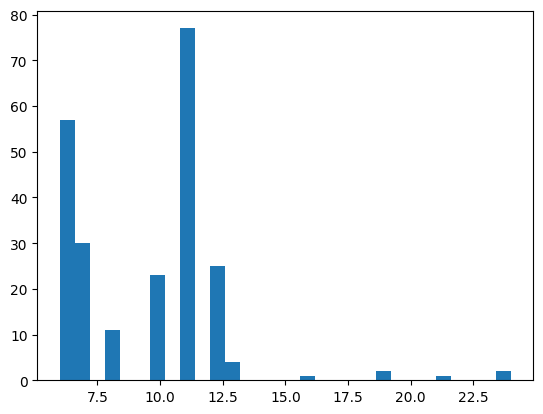

In [46]:
plt.hist(prog_lens, bins=30);

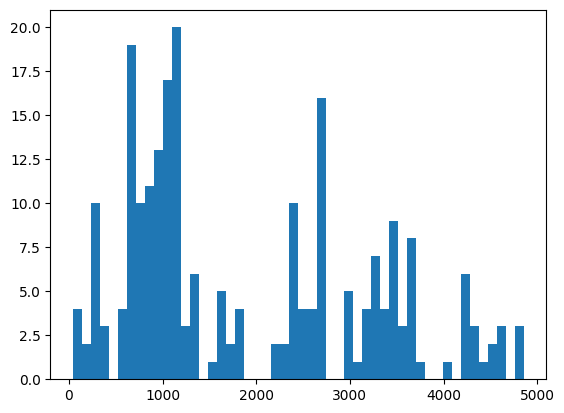

In [48]:
plt.hist(weight_lens, bins=50);

In [6]:
program_toks, weights = process_data(x, args.d_model)

In [7]:
rng, subrng = jax.random.split(rng)
params = model.init(subrng, weights, program_toks)

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:

logits, activation_stats = model_forward(
    {"params": params},
    weights,
    program_toks,
    is_training=is_training,
    rngs={"dropout": rng},
)
logits = logits[:, -len(program_toks):, :]
loss = optax.softmax_cross_entropy(logits, program_toks)
metrics = {}
aux = dict(outputs=logits, metrics=metrics)
return loss, aux

In [ ]:
model.apply(

)

In [ ]:
loss_fn = create_loss_fn(model.apply, args.d_model)

In [ ]:
loss_fn

<function __main__.create_loss_fn.<locals>.loss_fn(params: dict, rng: Union[jax.Array, numpy.ndarray, numpy.bool_, numpy.number, bool, int, float, complex], data: rasp_tokenizer.utils.RaspFlatDatapoint, is_training: bool = True)>